**Objective:**

We will try to gain more insight about the global household electric power consumption by using time series forecasting.

**Dataset Information:**
It is a real-world power usage data from a single household in Sceaux (7km of Paris, France), recorded at 1-minute intervals, between December 2006 and November 2010 (47month). Please refer more detail about the dataset in
<a href='https://vast-part-d09.notion.site/Data-Pipeline-Implementation-1bc7e6ac7d0780e19be3fcf311b4a4af?pvs=73'>Data Pipeline Implementation | Notion</a>

- The dataset consisted of **9 features**: 
    - **Date**: Date in format dd/mm/yyyy
    - **Time**: time in format hh:mm:ss
    - **Global_active_power**: household global minute-averaged active power (in kilowatt)
    - **Global_reactive_power**: household global minute-averaged reactive power (in kilowatt)
    - **Voltage**: household global minute-averaged reactive power (in kilowatt)
    - **Global_intensity**: household global minute-averaged current intensity (in ampere)
    - **Sub_metering_1**: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
    - **Sub_metering_2**: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
    - **Sub_metering_3**: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.
- Instances: 2075259

**For initial start we will conduct 6 primary steps:**

Data pre-processing -> Exploratory Data Analysis (EDA) -> Data preparation -> Building and Training LSTM model (train set) -> Model Evaluation -> Visualization

1. Data pre-processing: handle missing value, converting the data into a stationary time series
2. EDA: understanding pattern and trend
3. Data preparation: prepare and split data (train, test set) and transform data for LSTM
4. Building mode: we are using LSTM and SARIMA (Seasonal Autoregressive Integrated Moving Average) for comparison
5. Model evaluation: perform metrics on both sets
6. Visualization

**Good To Note**: In South Korea, residential electricity consumption accounts for a significant portion of total energy use, with households using an average of 363 kilowatt-hours (kWh) in August, and electricity prices are subject to a **'tiered rate'** system where higher usage leads to higher costs. Additionally, we should also consider about specific time events like holiday, policy changes, or tech upgrade. For example, in Geumcheon-myeon, Naju-si, South Korea is shifting its energy policy towards increased renewable energy and carbon neutrality, with plans to reduce coal reliance and increase nuclear power and renewable energy sources, aiming for 70.7% carbon-free energy by 2038. 

**Reference**
- <a href='https://www.koreatimes.co.kr/www/biz/2025/02/602_382142.html#:~:text=Extreme%20summer%20heat%20wave%20to%20markedly%20increase%20household%20energy%20burden,-An%20electricity%20bill&text=Extreme%20heat%20wave%20in%20August,the%20data%20was%20first%20recorded.'>Extreme summer heat wave to markedly increase household energy burden</a>
- <a href='https://home.kepco.co.kr/kepco/EN/F/B/ENFBPP002.do?menuCd=EN060202#:~:text=Residential%20Service%20*%20The%20Electric%20rate%20may,television%20reception%20fee%2C%20penalty%2C%20and%20other%20fees.'>Electric Rates Calculation | KEPCO</a>
- <a href='https://www.koreatimes.co.kr/www/tech/2025/03/129_384850.html#:~:text=Due%20to%20rising%20fuel%20costs,the%20company'>KEPCO hikes industrial electricity rates, keeps residential fees steady | TheKoreaTimes</a>
- <a href='https://www.ceicdata.com/en/korea/environmental-environmental-policy-taxes-and-transfers-oecd-member-annual/kr-residential-electricity-price-usd-per-kwh'>South Korea Residential Electricity Price: USD per kWh</a>
- <a href='https://www.iea.org/countries/korea/electricity'>Sources of electricity generation - provides data on electricity consumption by sector</a>
- <a href='https://epsis.kpx.or.kr/epsisnew/selectEkccIntroEn.do?menuId=090101'>The Ministry of Trade, Industry and Energy studied 'Construction and Operation of the Electric Power Statistics Database Structure on restructuring of the Electric Energy Market' for the effective operation of Electric Power Statistics and accordingly developed the Electric Power Statistics Information System (EPSIS : Electric Power Statistics Information System)</a>
- <a href='https://climateactiontracker.org/countries/south-korea/2022-03-08/policies-action/#:~:text=The%20target%20scenario%20in%20the,compared%20to%20the%20Eighth%20Plan.'>Policies & action | Climate Action Tracker</a>
- <a href='https://home.kepco.co.kr/kepco/EN/F/htmlView/ENFBHP00109.do?menuCd=EN060201'>Electric Rates Table | KEPCO</a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from time import time
from scipy import stats
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
import math
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.4f' % x)

sns.set_context("paper", font_scale=1.3)
sns.set_style('white')

warnings.filterwarnings('ignore')

import matplotlib.ticker as tkr

%matplotlib inline

##### Step 1: Data Pre-processing

In [2]:
df = pd.read_csv('D:/ai_team/self-dr-vpp/data/raw/household_power_consumption.txt', 
                   delimiter=';',
                   na_values='?',
                   parse_dates={'datetime': ['Date', 'Time']},
                   infer_datetime_format=True,
                   low_memory=False)

In [3]:
print(' Number of rows and columns:', df.shape)
df.head(5)

 Number of rows and columns: (2075259, 8)


,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.2160,0.4180,234.8400,18.4000,0.0000,1.0000,17.0000
1,2006-12-16 17:25:00,5.3600,0.4360,233.6300,23.0000,0.0000,1.0000,16.0000
2,2006-12-16 17:26:00,5.3740,0.4980,233.2900,23.0000,0.0000,2.0000,17.0000
3,2006-12-16 17:27:00,5.3880,0.5020,233.7400,23.0000,0.0000,1.0000,17.0000
4,2006-12-16 17:28:00,3.6660,0.5280,235.6800,15.8000,0.0000,1.0000,17.0000


In [4]:
# convert all data columns name to lowercase and remove spaces
df.columns = [col.lower() for col in df.columns]

In [5]:
print('Data information:', df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   datetime               datetime64[ns]
 1   global_active_power    float64       
 2   global_reactive_power  float64       
 3   voltage                float64       
 4   global_intensity       float64       
 5   sub_metering_1         float64       
 6   sub_metering_2         float64       
 7   sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB
Data information: None


In [6]:
print('Data description:', df.describe())

Data description:                             datetime  global_active_power  \
count                        2075259         2049280.0000   
mean   2008-12-06 07:12:59.999994112               1.0916   
min              2006-12-16 17:24:00               0.0760   
25%              2007-12-12 00:18:30               0.3080   
50%              2008-12-06 07:13:00               0.6020   
75%              2009-12-01 14:07:30               1.5280   
max              2010-11-26 21:02:00              11.1220   
std                              NaN               1.0573   

       global_reactive_power      voltage  global_intensity  sub_metering_1  \
count           2049280.0000 2049280.0000      2049280.0000    2049280.0000   
mean                  0.1237     240.8399            4.6278          1.1219   
min                   0.0000     223.2000            0.2000          0.0000   
25%                   0.0480     238.9900            1.4000          0.0000   
50%                   0.1000     241.

In [7]:
df.tail(5)

,datetime,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
2075254,2010-11-26 20:58:00,0.9460,0.0000,240.4300,4.0000,0.0000,0.0000,0.0000
2075255,2010-11-26 20:59:00,0.9440,0.0000,240.0000,4.0000,0.0000,0.0000,0.0000
2075256,2010-11-26 21:00:00,0.9380,0.0000,239.8200,3.8000,0.0000,0.0000,0.0000
2075257,2010-11-26 21:01:00,0.9340,0.0000,239.7000,3.8000,0.0000,0.0000,0.0000
2075258,2010-11-26 21:02:00,0.9320,0.0000,239.5500,3.8000,0.0000,0.0000,0.0000


Feature Engineering

In [8]:
# Convert the Global_active_power to numeric and remove missing values
df['global_active_power'] = pd.to_numeric(df['global_active_power'], errors='coerce')
df = df.dropna(subset=['global_active_power'])

In [9]:
df['datetime'] = pd.to_datetime(df['datetime'])  
df.tail(2)

,datetime,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
2075257,2010-11-26 21:01:00,0.9340,0.0000,239.7000,3.8000,0.0000,0.0000,0.0000
2075258,2010-11-26 21:02:00,0.9320,0.0000,239.5500,3.8000,0.0000,0.0000,0.0000


In [11]:
# create new columns for year, quarter, month, day, hour and minute, we are using dt(change over time) accessor instead of 
    # lamda function for better datetime extraction
df['year']    = df['datetime'].dt.year
df['quarter'] = df['datetime'].dt.quarter
df['month']   = df['datetime'].dt.month
df['day']     = df['datetime'].dt.day
df['hour']    = df['datetime'].dt.hour
df['minute']  = df['datetime'].dt.minute
df['weekday']  = df['datetime'].dt.weekday

#Map Weekday/Weekend Label
# 1 = Weekday, 0 = Weekend
df['is_weekday'] = (df['weekday'] < 5).astype(int)
df['weekday_label'] = df['is_weekday'].map({1: 'Weekday', 0: 'Weekend'})

season + time-category classification 

In [12]:
# STEP 1: Define season
def get_season(month):
    if month in [6, 7, 8]:
        return 'summer'
    elif month in [3, 4, 5, 9, 10]:
        return 'spring_fall'
    else:
        return 'winter'

df['season'] = df['month'].apply(get_season)

In [13]:
# STEP 2: Define time category
def classify_time_of_use(row):
    hour = row['hour']
    season = row['season']
    
    if season in ['summer', 'spring_fall']:
        if 22 <= hour or hour < 8:
            return 'off-peak'
        elif (8 <= hour < 11) or (12 <= hour < 13) or (18 <= hour < 22):
            return 'mid-peak'
        elif (11 <= hour < 12) or (13 <= hour < 18):
            return 'on-peak'
    elif season == 'winter':
        if 22 <= hour or hour < 8:
            return 'off-peak'
        elif (8 <= hour < 9) or (12 <= hour < 16) or (19 <= hour < 22):
            return 'mid-peak'
        elif (9 <= hour < 12) or (16 <= hour < 19):
            return 'on-peak'
    return 'unknown'

df['time_category'] = df.apply(classify_time_of_use, axis=1)

Use Cases for weekday:
- Compare usage on weekdays vs. weekends
- Combine with hour to find peak usage patterns (Monday 6–9PM)

In [14]:
df[['datetime', 'weekday', 'is_weekday', 'weekday_label']].sample(5) #test

,datetime,weekday,is_weekday,weekday_label
1979151,2010-09-21 03:15:00,1,1,Weekday
480369,2007-11-15 07:33:00,3,1,Weekday
552065,2008-01-04 02:29:00,4,1,Weekday
1681082,2010-02-26 03:26:00,4,1,Weekday
364799,2007-08-27 01:23:00,0,1,Weekday


In [16]:
# keep only the columns such as  
df = df.loc[:, [
    'datetime', 'global_active_power', 'year', 'quarter', 'month', 'day',
    'hour', 'minute', 'weekday', 'season', 'time_category'
]]

In [18]:
# sort data by datetime
df.sort_values('datetime', inplace=True, ascending=True)

In [19]:
# reset index
df = df.reset_index(drop=True)

In [20]:
print('Number of rows and columns:', df.shape)
print('Minimum datetime:', df.datetime.min())
print('Maximum datetime:', df.datetime.max())

df.tail(5)

Number of rows and columns: (2049280, 11)
Minimum datetime: 2006-12-16 17:24:00
Maximum datetime: 2010-11-26 21:02:00


,datetime,global_active_power,year,quarter,month,day,hour,minute,weekday,season,time_category
2049275,2010-11-26 20:58:00,0.9460,2010,4,11,26,20,58,4,winter,mid-peak
2049276,2010-11-26 20:59:00,0.9440,2010,4,11,26,20,59,4,winter,mid-peak
2049277,2010-11-26 21:00:00,0.9380,2010,4,11,26,21,0,4,winter,mid-peak
2049278,2010-11-26 21:01:00,0.9340,2010,4,11,26,21,1,4,winter,mid-peak
2049279,2010-11-26 21:02:00,0.9320,2010,4,11,26,21,2,4,winter,mid-peak


Normality testing target on global_active_power.
- We need to check if the data is normally distributed 
- The determination is base on D'Agostino's K^2 Test
- We will initialized a p-value for our hypothesis

Hypothesis (H0,H1): 
```python
alpha = 0.05

if p_value <= alpha, we will reject H0: global_active_power is not normally distributed 
else:
p_value > alpha, we will to reject H0: global_active_power appears normally distributed
```

In [21]:
import scipy.stats as stats

stat, p_value = stats.normaltest(df['global_active_power'])  # D'Agostino and Pearson's Test
print('Statistics=%.3f, p=%.3f' % (stat, p_value))

if p_value < 0.05:
    print('Reject H0: The distribution of global active power is not normal')
else:
    print('Fail to reject H0: The distribution of global active power is normal')

Statistics=724881.795, p=0.000
Reject H0: The distribution of global active power is not normal


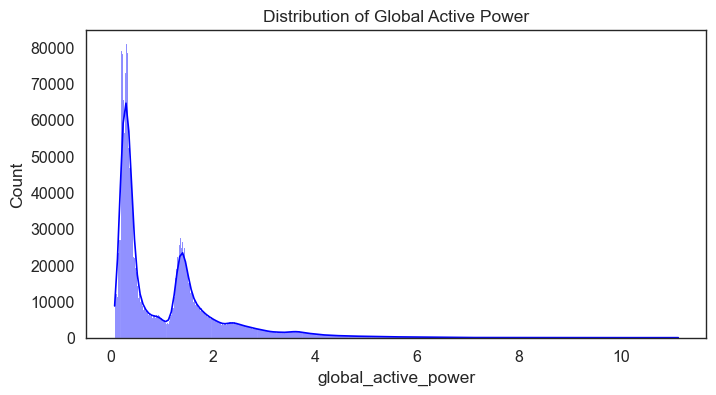

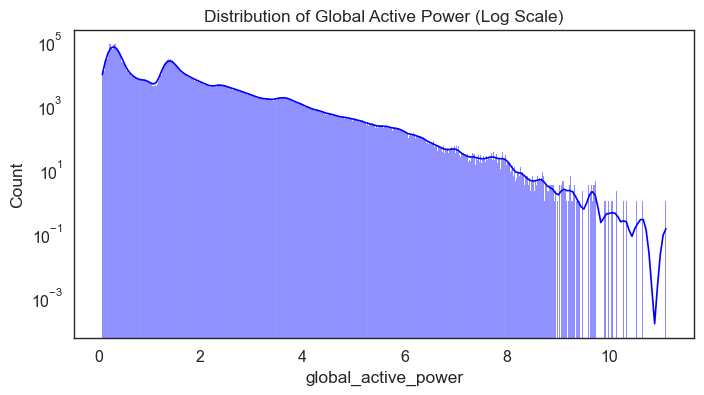

Text(0.5, 1.0, 'Histogram of Global Active Power')

In [22]:
# plot the distribution of global active power
plt.figure(figsize=(8,4))
sns.histplot(df['global_active_power'], kde=True, color='blue')
plt.title('Distribution of Global Active Power')
plt.show()

# plot the distribution of global active power on a log scale
plt.figure(figsize=(8,4))
sns.histplot(df['global_active_power'], kde=True, color='blue')
plt.yscale('log')
plt.title('Distribution of Global Active Power (Log Scale)')
plt.show() 

# histogram and Q-Q plot
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.histplot(df['global_active_power'], kde=True, color='blue')
plt.title('Histogram of Global Active Power')


In [23]:
# kurtosis of normal distribution (Fisher-Pearson coefficient of kurtosis)
kurtosis = stats.kurtosis(df['global_active_power'])
print('Kurtosis:', kurtosis)

# skewness of normal distribution
skewness = stats.skew(df['global_active_power'])
print('Skewness:', skewness)

Kurtosis: 4.218671866132123
Skewness: 1.7862320846320818


### Summary Insight of Kurtosis and Skewness

- **Kurtosis (4.22)**: The kurtosis value is greater than 3, indicating that the distribution of `global_active_power` has heavier tails compared to a normal distribution. This suggests the presence of outliers or extreme values in the data.

- **Skewness (1.79)**: The skewness value is positive, indicating that the distribution of `global_active_power` is right-skewed. This means that the data has a longer tail on the right side, with a concentration of values on the lower end.

So, we are looking for a symmetry skewness between -0.5 and 0.5 to be consider fairly symmetrical. However, if the skewness fall between -1 & -0.5 or 0.5 & 1, the data is considered moderately skew. In our case, the skewness shown greater than 1, which indicated a highly skewed data. Therefore, these insights suggest that the data is not normally distributed, as confirmed by the p-value from the normality test (`p_value = 0.0`), which leads to rejecting the null hypothesis of normality.

##### Step 2: Exploratory Data Analysis (EDA)

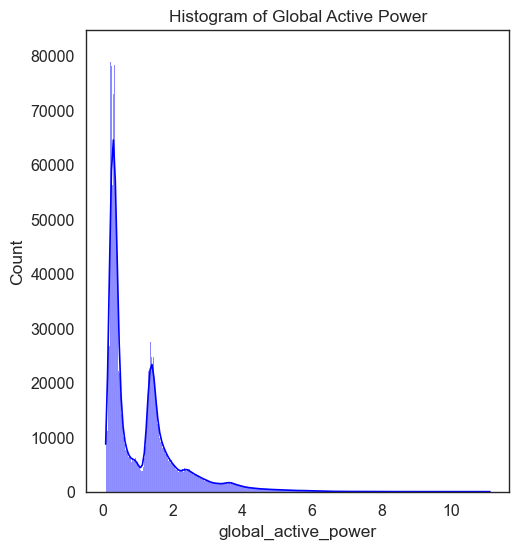

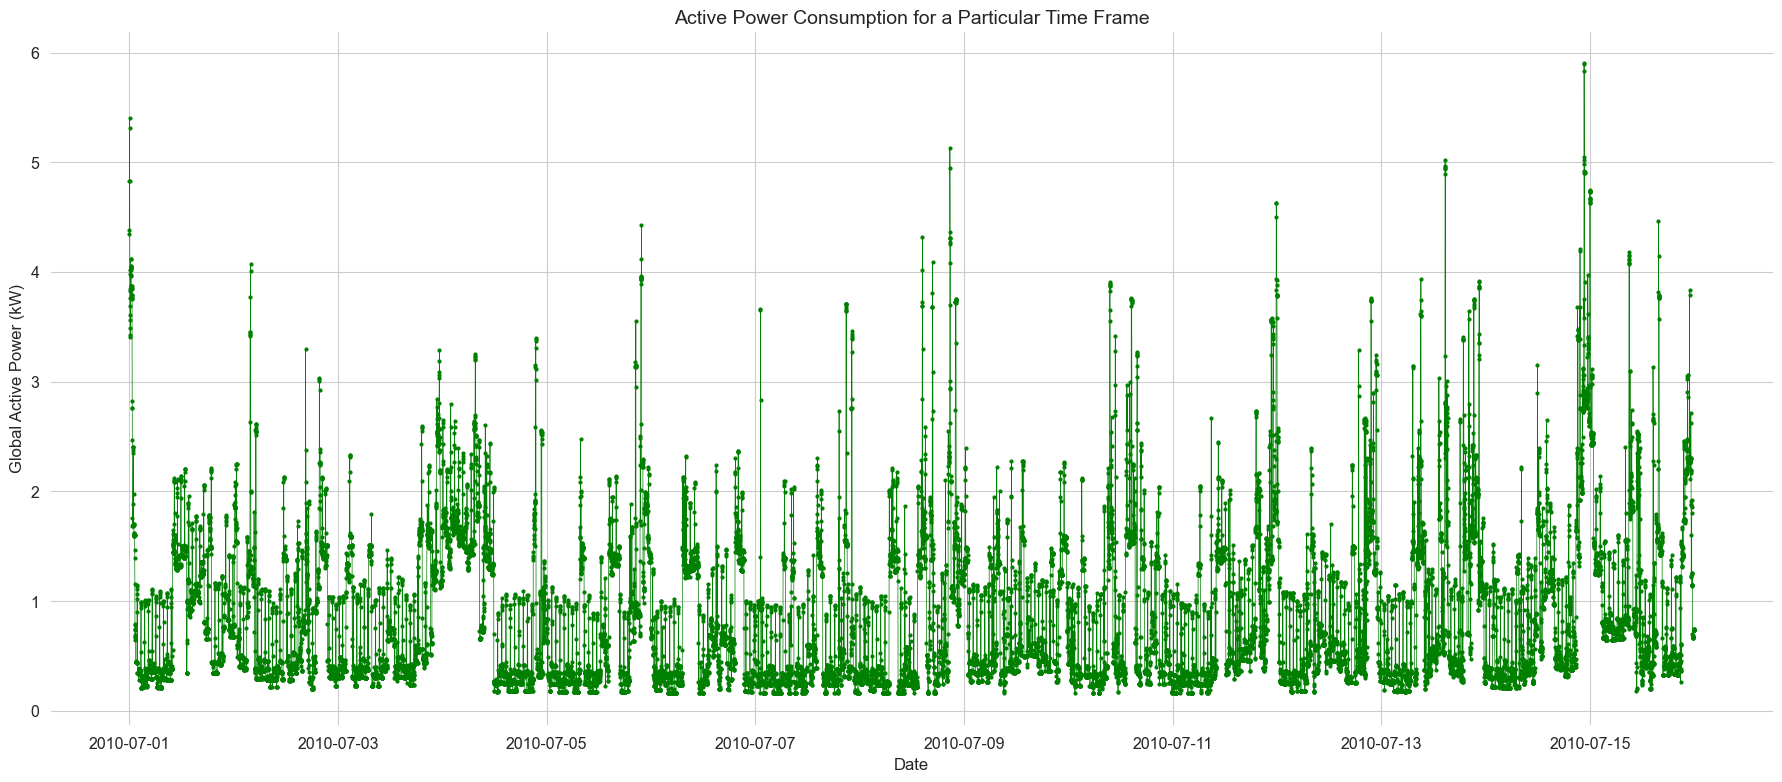

In [24]:
data_timeframe = df[(df.datetime >= '2010-07-01') & (df.datetime < '2010-7-16')]

plt.figure(figsize=(18,8))
plt.plot(data_timeframe.datetime, data_timeframe.global_active_power, color='green', marker='o', linestyle='-', linewidth=0.5, markersize=2)
plt.ylabel('Global Active Power (kW)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.title('Active Power Consumption for a Particular Time Frame', fontsize=14)
plt.tight_layout()
plt.grid(True)
sns.despine(bottom=True, left=True)
plt.show()

- Frequent fluctuation in power consumption (which is expected)
- Most consumption stay below ~4KW and occasional spikes between ~6-8KW -> this might be due to some seasonal changes 

=> This meaning that the electricity power usage is not constant and fluctuated and change overtime (dynamic and un-uniform)

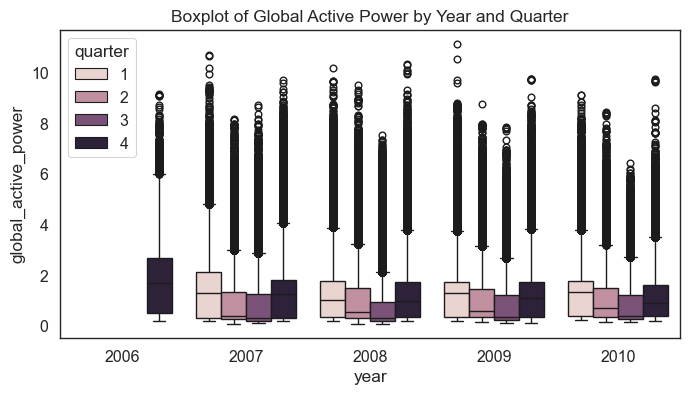

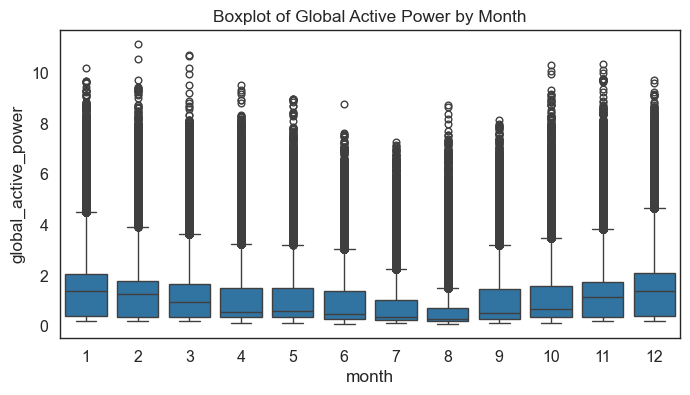

In [25]:
# compare plot of global active power by year and quarter
plt.figure(figsize=(8,4))
sns.boxplot(x='year', y='global_active_power', hue='quarter', data=df)
plt.title('Boxplot of Global Active Power by Year and Quarter')
plt.show()

# compare the distribution of global active power by month
plt.figure(figsize=(8,4))
sns.boxplot(x='month', y='global_active_power', data=df)
plt.title('Boxplot of Global Active Power by Month')
plt.show()

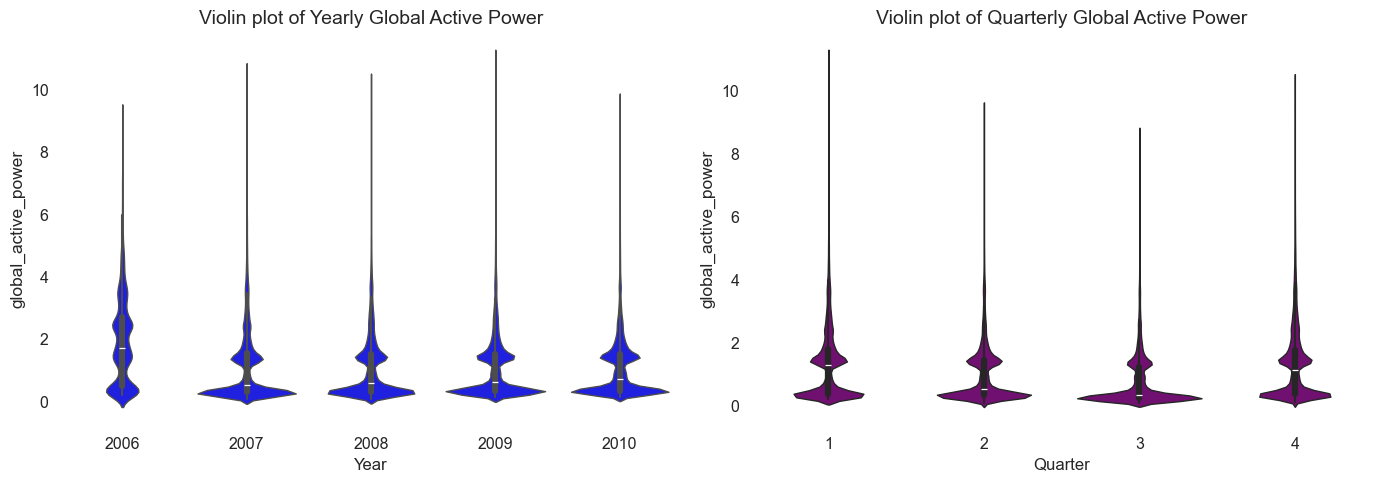

In [26]:
# compare violin plot of global active power by year and quarter and add a tight layout to the plot
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.violinplot(x="year", y="global_active_power", data=df, color='blue')
plt.xlabel('Year', fontsize=12)
plt.title('Violin plot of Yearly Global Active Power', fontsize=14)
sns.despine(left=True, bottom=True)
plt.tight_layout() 

plt.subplot(1,2,2)
sns.violinplot(x="quarter", y="global_active_power", data=df, color='purple')
plt.xlabel('Quarter', fontsize=12)
plt.title('Violin plot of Quarterly Global Active Power', fontsize=14)
sns.despine(left=True, bottom=True)
plt.tight_layout()

plt.show()

To better understand the range distribution within the data we are using both box plot and violin plot.

How to read a violin plot:
- the white dot represent the median
- the thick gray bar in the center represents the interQuartiles range 
- the thin gray line represents the rest of the distribution, except for points that are determined to be "outliers" using a method that is a function of the interquartile range

Our chart interpretation:
- in here each violin represents the density of power consumption per year
- at a glance it seems most year has similar pattern from 2006-2010 
- as for the median, also appear to be consistent over each year except for 2006 
- and some outliers extend to higher power consumption levels
- if we look at the quarterly distribution it indicates subtle seasonal variations that looks relatively similar, however we also notice there is a slight variation width in some quarter as well, which might suggests there is some different consumption patterns.

**For example** 
- typical daily consumption range between 1-4kW (Kimchi fridge, Air-con/Fan, Fridge, Rice cooker, Laundry Machine, etc). 
- Occasional spikes reach 6-8kW might likely due to dinner preparation, running multiple appliances simultaneously, or during running Electric heating/cooling (winter/summer). 

The power consumptions is relatively stable year-round, eventhough there are some slight seasonal variations exit. Based on the patterns we could conclude that in the 1st and 4th (winter: Oct, Nov, Dec, Jan, Feb, Mar) quarters and lowest during 3rd quarter (summer: Jul, Aug, Sep)

In [ ]:
# # print adfuller test results
# result = adfuller(df['global_active_power'])
# print('ADF Statistic:', result[0])
# print('p-value:', result[1])

# This is taking too much memory and comooutational power, so we will skip this for now -> it was intented to check if the data is stationary or not for time series analysis

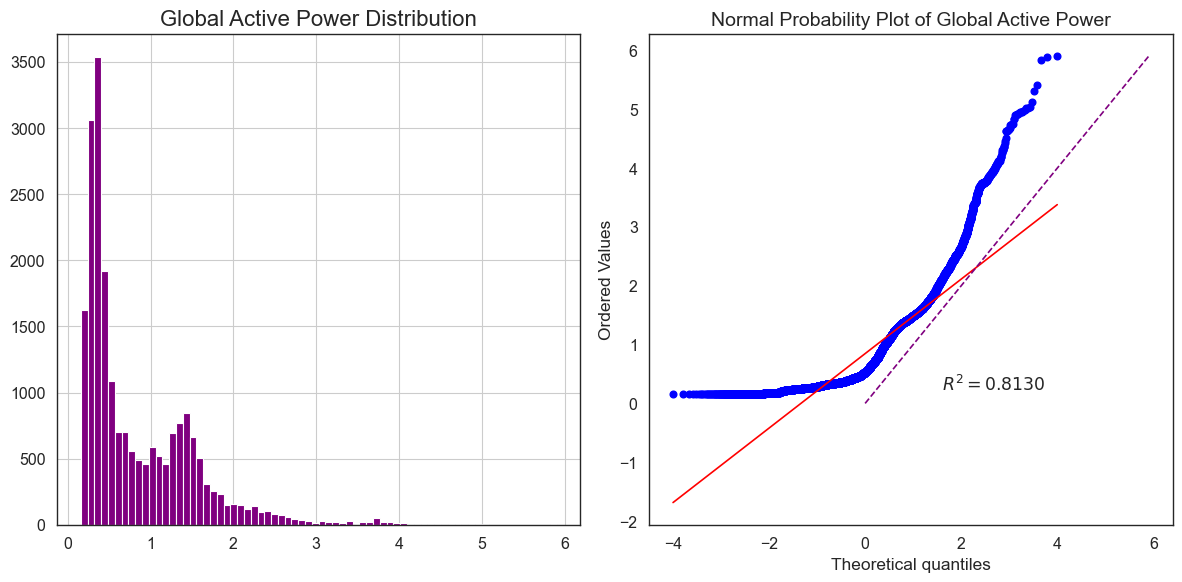

                         count                           mean  \
datetime                 21599  2010-07-08 11:59:01.572294912   
global_active_power 21599.0000                         0.8464   
year                21599.0000                      2010.0000   
quarter             21599.0000                         3.0000   
month               21599.0000                         7.0000   
day                 21599.0000                         7.9997   
hour                21599.0000                        11.4999   
minute              21599.0000                        29.4998   
weekday             21599.0000                         3.0000   

                                     min                  25%  \
datetime             2010-07-01 00:00:00  2010-07-04 17:59:30   
global_active_power               0.1580               0.3360   
year                           2010.0000            2010.0000   
quarter                           3.0000               3.0000   
month                   

In [27]:
plt.figure(figsize=(12,6))

# Histogram 
plt.subplot(1,2,1)
data_timeframe['global_active_power'].hist(bins=70, color='purple')
plt.title('Global Active Power Distribution', fontsize=16)

# Normal Probability 
plt.subplot(1,2,2)
# normal probability  
stats.probplot(data_timeframe['global_active_power'], plot=plt, fit=True, rvalue=True) 
plt.plot([0, max(data_timeframe['global_active_power'])], [0, max(data_timeframe['global_active_power'])], color='purple', linestyle='--')
plt.title('Normal Probability Plot of Global Active Power', fontsize=14)

plt.tight_layout()
plt.show()
print(data_timeframe.describe().T)

In [29]:
# Create a new data_timeframe DataFrame focused on just the timestamp + power consumption, and set 'datetime' as the index → required for resampling
data_timeframe = df.loc[:, ['datetime', 'global_active_power']]
data_timeframe.set_index('datetime', inplace=True)

In [28]:
df.head(2)

,datetime,global_active_power,year,quarter,month,day,hour,minute,weekday,season,time_category
0,2006-12-16 17:24:00,4.2160,2006,4,12,16,17,24,5,winter,on-peak
1,2006-12-16 17:25:00,5.3600,2006,4,12,16,17,25,5,winter,on-peak


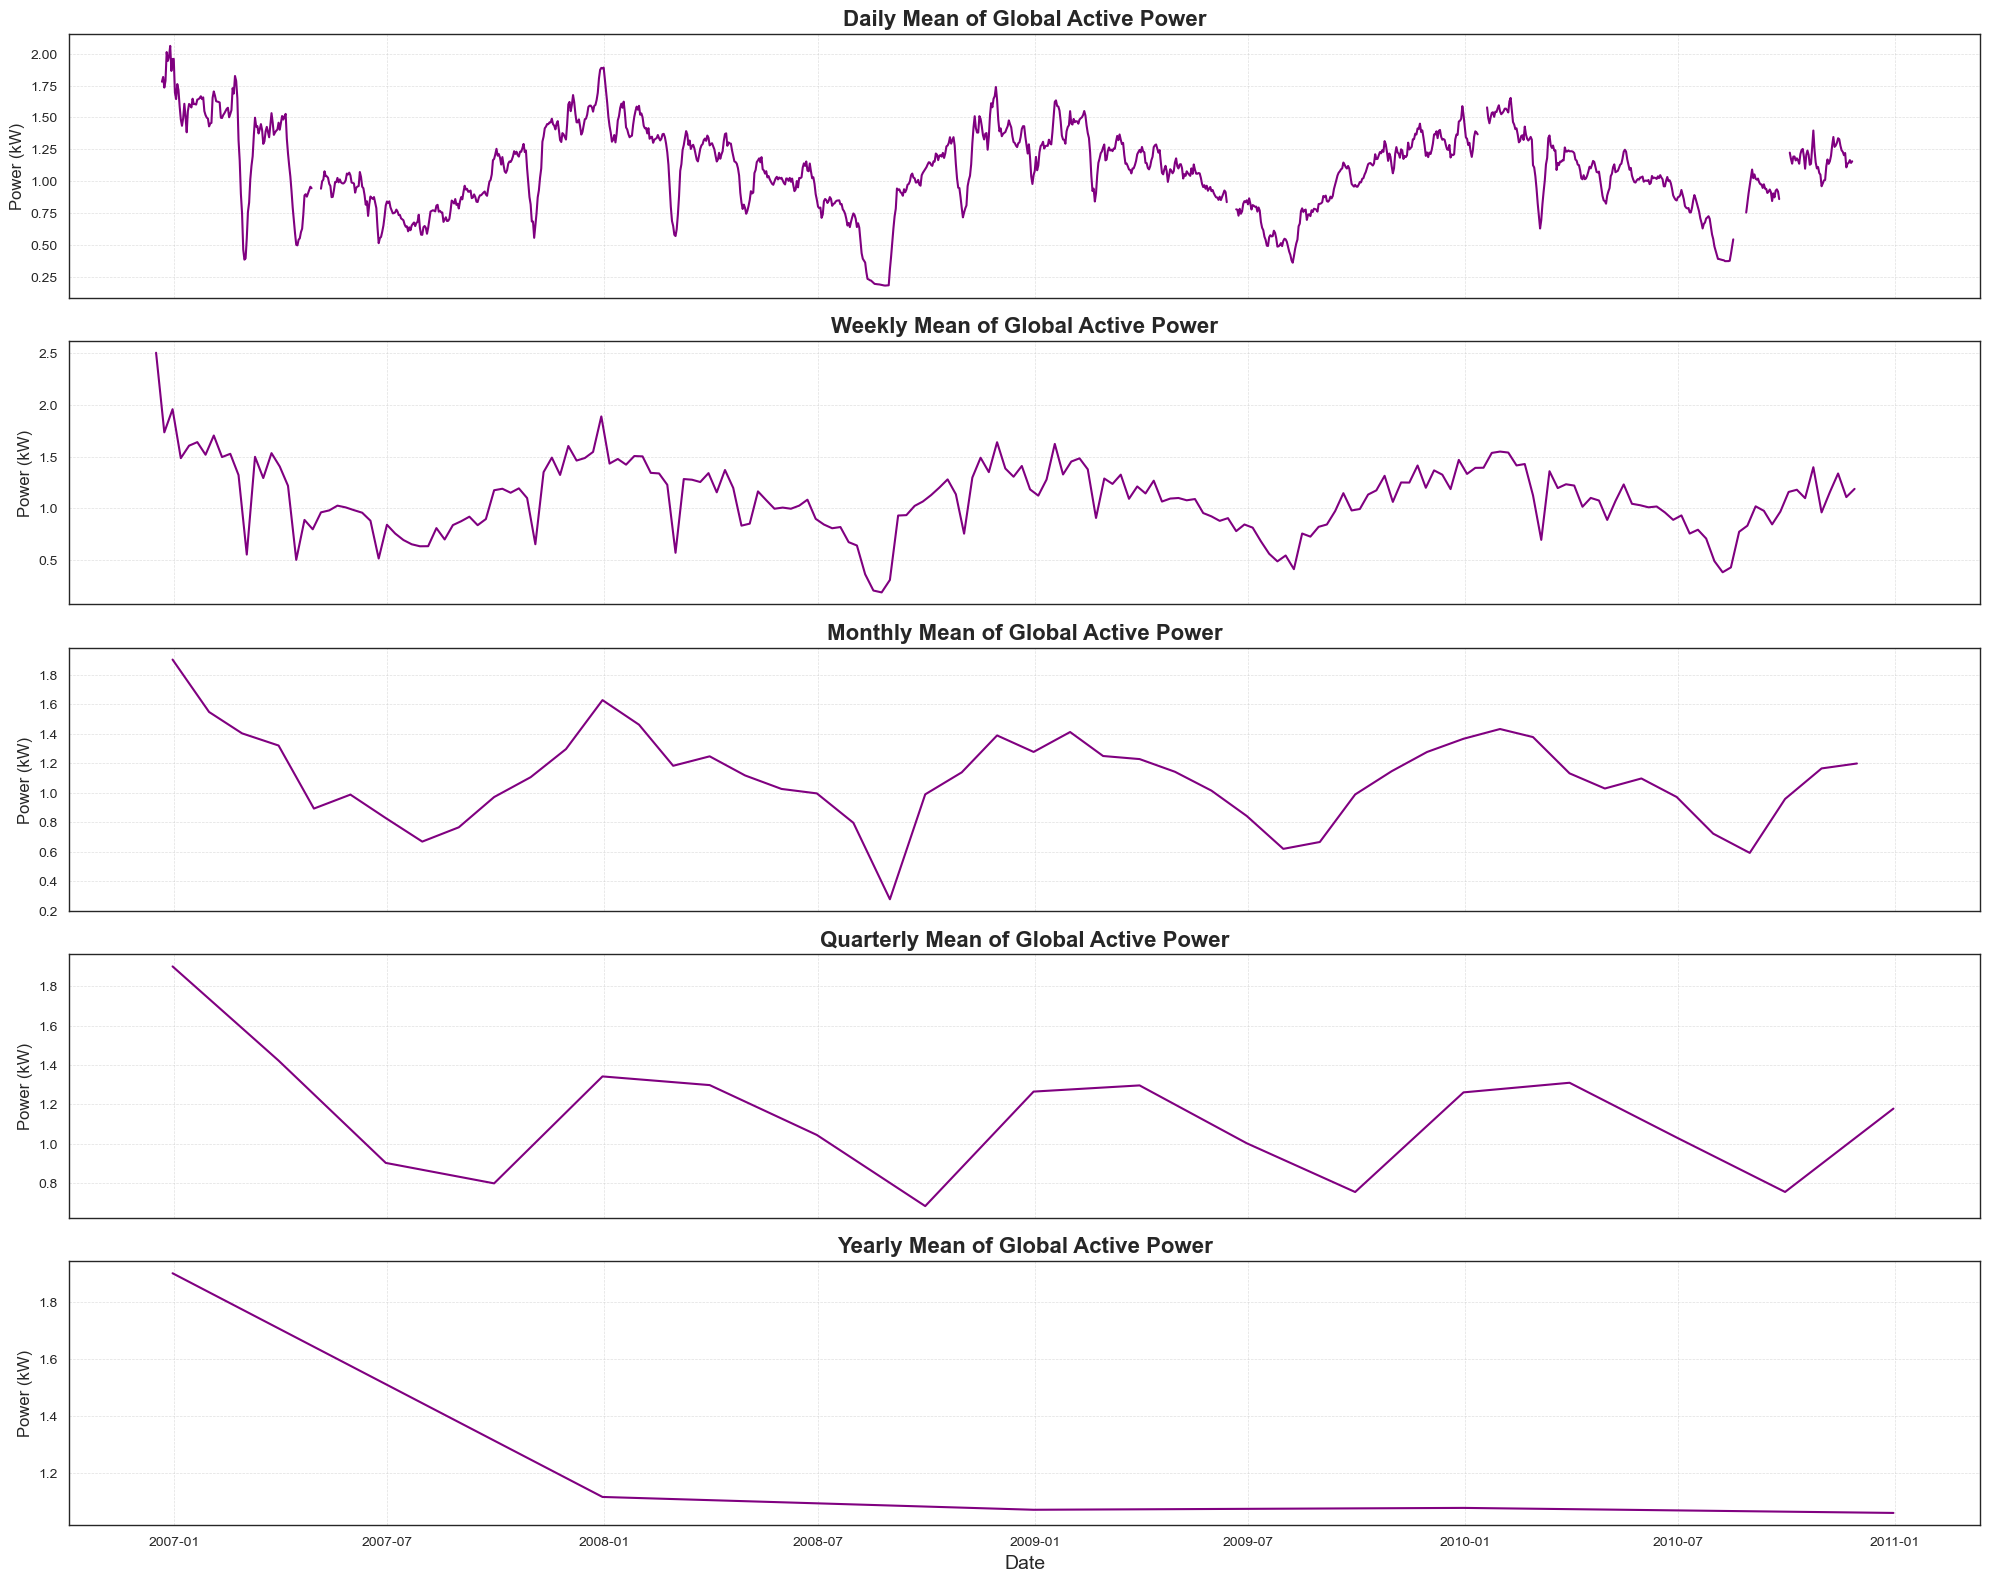

In [30]:
resample_rules = ['D', 'W', 'M', 'Q', 'A']
titles = [
    'Daily Mean of Global Active Power',
    'Weekly Mean of Global Active Power',
    'Monthly Mean of Global Active Power',
    'Quarterly Mean of Global Active Power',
    'Yearly Mean of Global Active Power'
]

# precompute resampled data
# resampled_data = [data_timeframe['global_active_power'].resample(rule).mean() for rule in resample_rules]
resampled_data = [
    data_timeframe['global_active_power'].resample(rule).mean().rolling(window=7).mean()
    if rule == 'D' else data_timeframe['global_active_power'].resample(rule).mean()
    for rule in resample_rules
]

# create subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(20, 16), sharex=True)
fig.subplots_adjust(hspace=0.6)

for ax, df_resampled, title in zip(axes, resampled_data, titles):
    ax.plot(df_resampled, linewidth=1.5, color='purple')
    ax.set_title(title, fontsize=16, weight='bold')
    ax.set_ylabel('Power (kW)', fontsize=12)
    ax.tick_params(axis='both', labelsize=10)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

axes[-1].set_xlabel('Date', fontsize=14)
plt.tight_layout()
plt.show()

As time granularity becomes coarser (from days-to-years), the plot smooth out the initial short-term noises we see in the daily consumption.
- Daily: as expected to be noisy and spiky, it shown a lot of short-term fluctuation too -> will be great for predicting daily usage behavior or outlier events such as high spikes from heater/oven/cooling and more
- Weekly: show medium-range -> will be helpful in finding consumer's weekly habits and short seasonal effects
- Monthly: it look much stable however there are a slight dip in the 2nd quarter (mid 2008-2009) -> this might due to seasonal effects (spring season)
- Quarterly: understanding seasonal variations — winter vs. summer energy use
- Yearly: indicates a sharp steep from 2007-2009 then flatten (unknown reason)

Dickey-Fuller test statistical test to determine the stationarity of a time series

In [31]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(data_timeframe, resample_rule='D', maxlag=30):
    """
    Performs Dickey-Fuller Test on a resampled version of the input series to reduce memory usage.

    Parameters:
    - data_timeframe: pd.Series of the time series to test (e.g., data['global_active_power'])
    - resample_rule: 'D', 'W', etc. to downsample data before testing
    - maxlag: maximum lag to consider in ADF test
    """

    # Drop missing values early
    series = data_timeframe.dropna()

    # Downsample to reduce memory usage
    if resample_rule:
        series = series.resample(resample_rule).mean().dropna()

    # Rolling statistics
    rolmean = series.rolling(window=30).mean()
    rolstd = series.rolling(window=30).std()

    # Plot
    plt.figure(figsize=(20, 5))
    sns.despine(left=True)
    plt.plot(series, color='purple', label='Original')
    plt.plot(rolmean, color='orange', label='Rolling Mean (30)')
    plt.plot(rolstd, color='cyan', label='Rolling Std (30)')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation (Resampled)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # ADF Test
    print('\n<Results of Dickey-Fuller Test>\n')
    dftest = adfuller(series, maxlag=maxlag, autolag=None)
    dfoutput = pd.Series(dftest[0:4], index=[
        'Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used'
    ])

    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value

    print(dfoutput)

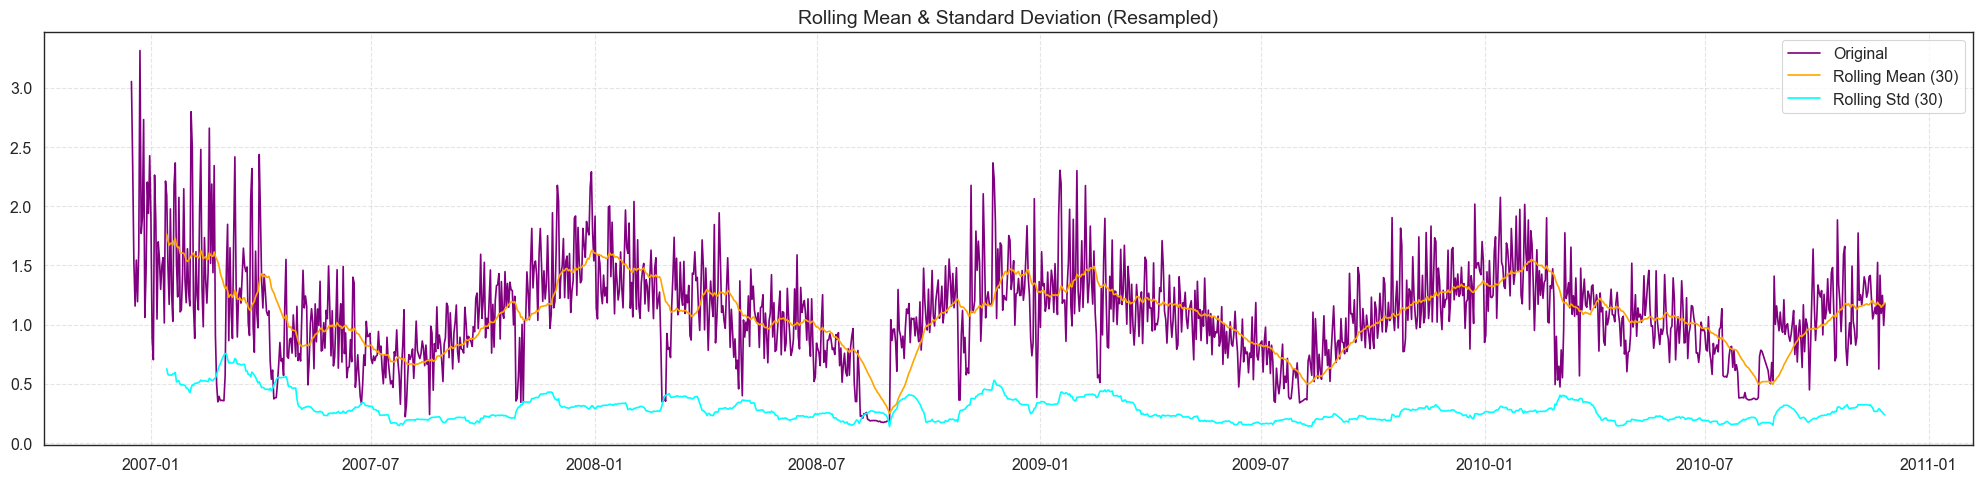


<Results of Dickey-Fuller Test>

Test Statistic                  -3.6538
p-value                          0.0048
# Lags Used                     20.0000
Number of Observations Used   1412.0000
Critical Value (1%)             -3.4350
Critical Value (5%)             -2.8636
Critical Value (10%)            -2.5679
dtype: float64


In [32]:
test_stationarity(data_timeframe['global_active_power'], resample_rule='D', maxlag=20)

Testing stationarity for resample rule 'H' with maxlag=30


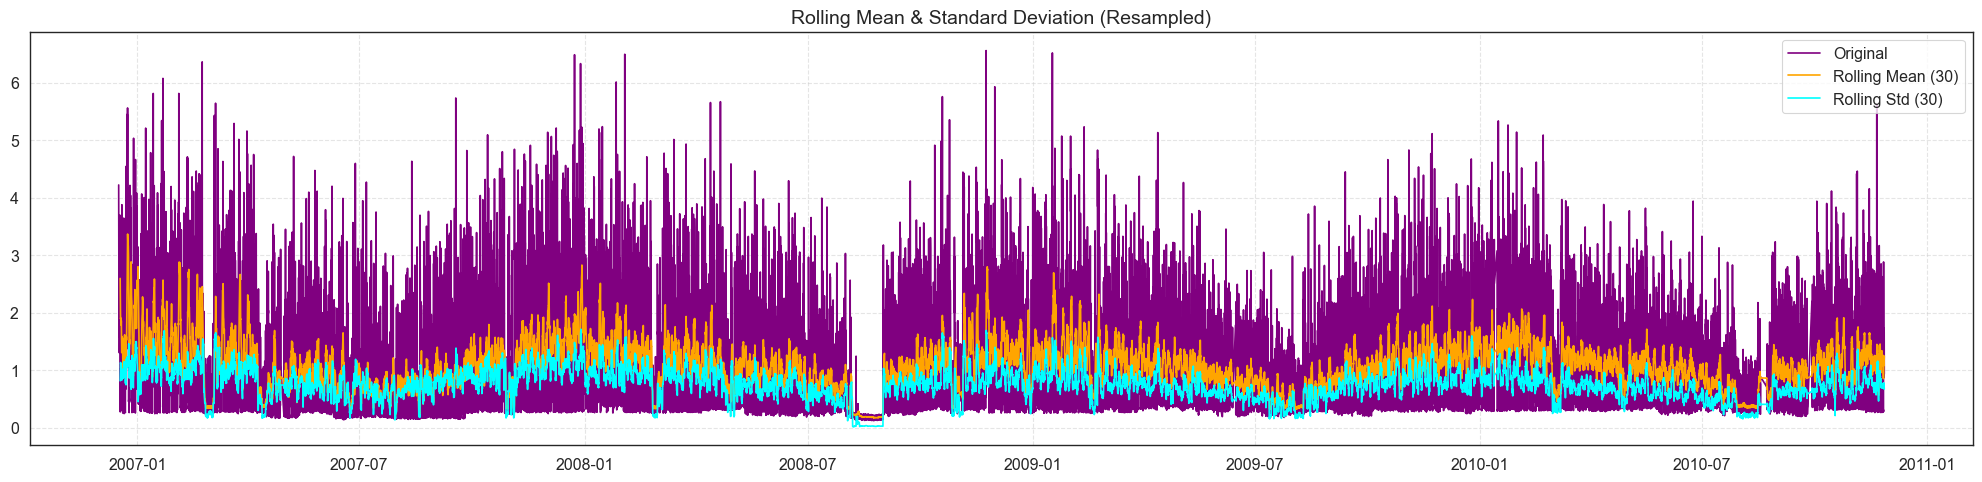


<Results of Dickey-Fuller Test>

Test Statistic                  -19.8650
p-value                           0.0000
# Lags Used                      30.0000
Number of Observations Used   34137.0000
Critical Value (1%)              -3.4305
Critical Value (5%)              -2.8616
Critical Value (10%)             -2.5668
dtype: float64
Testing stationarity for resample rule 'W' with maxlag=30


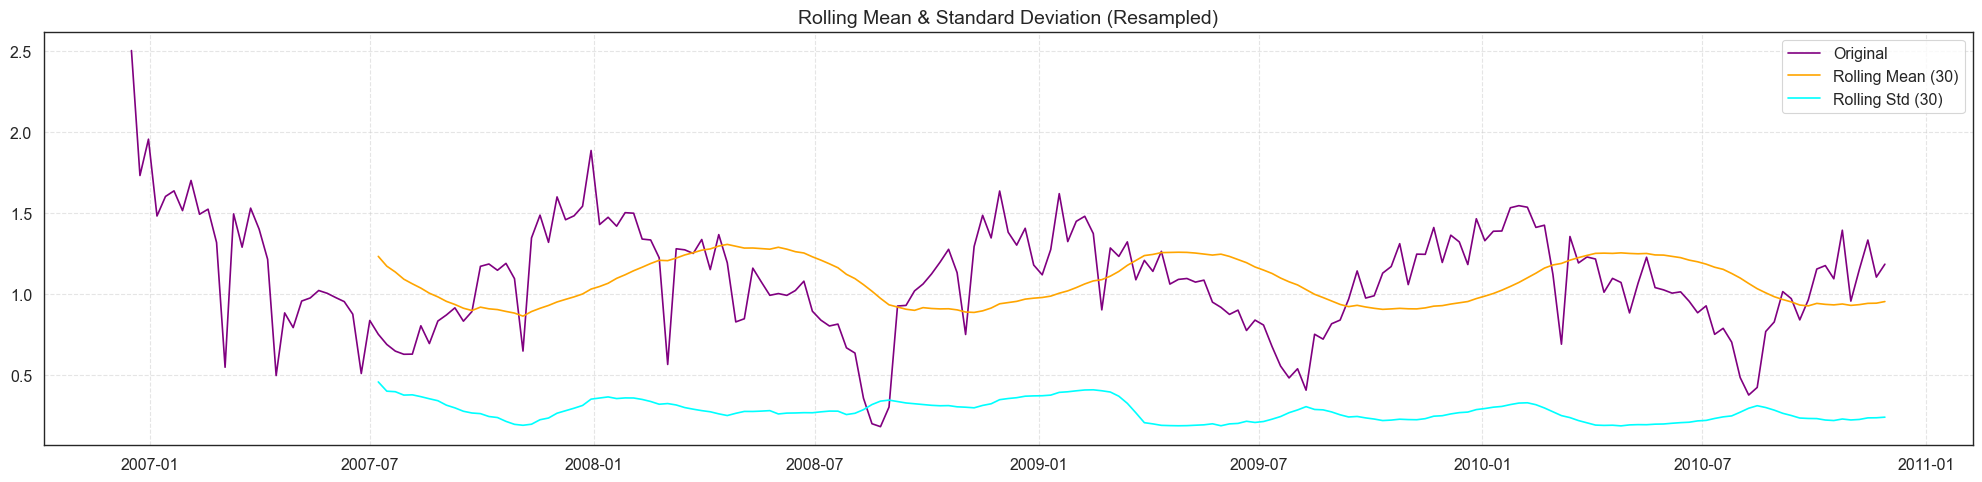


<Results of Dickey-Fuller Test>

Test Statistic                 -5.4055
p-value                         0.0000
# Lags Used                    30.0000
Number of Observations Used   176.0000
Critical Value (1%)            -3.4681
Critical Value (5%)            -2.8781
Critical Value (10%)           -2.5756
dtype: float64
Testing stationarity for resample rule 'M' with maxlag=22


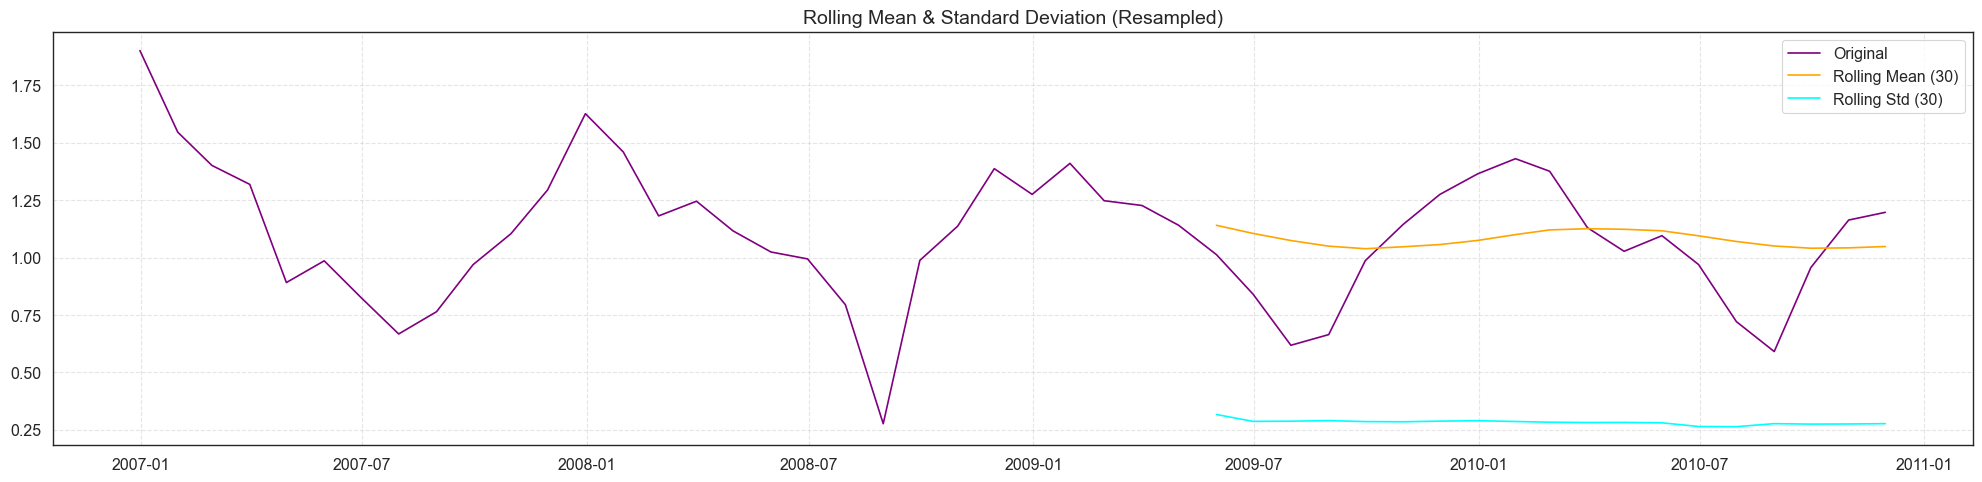


<Results of Dickey-Fuller Test>

Test Statistic                -1.2284
p-value                        0.6613
# Lags Used                   22.0000
Number of Observations Used   25.0000
Critical Value (1%)           -3.7239
Critical Value (5%)           -2.9865
Critical Value (10%)          -2.6328
dtype: float64


In [38]:
# Dynamically calculate maxlag based on the number of observations in the resampled data
for rule in ['H', 'W', 'M']:
	resampled_series = data_timeframe['global_active_power'].resample(rule).mean().dropna()
	maxlag = min(30, (len(resampled_series) // 2) - 1 - 1)  # Ensure maxlag is valid
	print(f"Testing stationarity for resample rule '{rule}' with maxlag={maxlag}")
	test_stationarity(resampled_series, resample_rule=None, maxlag=maxlag)

- Rolling Mean 30: this is the average of the last 30days (we resampled daily) -> smooth out the original signal to highlight the underling trends. So far it shown a stable pattern suggest that it is stationary enough to feed to the model
- Rolling Std 30: we are trying to measure the volatility -> the trend suggests a stable/flat std which means consistent fluctuations, whereas high std shows unstable behavior/.

Based on each year we might need to consider the innovation of technology trend, policy changes, and so one, in order to predict the power demand.

**Summary Across Granularities**
- H: many spikes + non-stationary
- D: still has noise + non-stationary
- W: some seasonality presents
- M: show trend + stationary 

##### Step 3: Data Preparation for Modeling

In [39]:
#Transform the global_active_power column of the data DataFrame into a numpy array of float values

dataset = df['global_active_power'].values.astype('float32')
#Reshape the numpy array into a 2D array with 1 column 
dataset = np.reshape(dataset, (-1, 1))
#Create an instance of the MinMaxScaler class to scale the values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
#Fit the MinMaxScaler to the transformed data and transform the values
dataset = scaler.fit_transform(dataset)

#Split the transformed data into a training set (80%) and a test set (20%)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

df.head(5)

,datetime,global_active_power,year,quarter,month,day,hour,minute,weekday,season,time_category
0,2006-12-16 17:24:00,4.2160,2006,4,12,16,17,24,5,winter,on-peak
1,2006-12-16 17:25:00,5.3600,2006,4,12,16,17,25,5,winter,on-peak
2,2006-12-16 17:26:00,5.3740,2006,4,12,16,17,26,5,winter,on-peak
3,2006-12-16 17:27:00,5.3880,2006,4,12,16,17,27,5,winter,on-peak
4,2006-12-16 17:28:00,3.6660,2006,4,12,16,17,28,5,winter,on-peak


In [40]:
def create_dataset(dataset, look_back=24):  # use 24 for 24 hours
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i+look_back])
        Y.append(dataset[i+look_back])
    return np.array(X), np.array(Y)

look_back = 24  # for 24-hour lookback
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

In [41]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test  = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [43]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1639400, 24, 1), (1639400, 1), (409832, 24, 1), (409832, 1))

In [45]:
X_train_small = X_train[:200_000]
y_train_small = y_train[:200_000]
X_test_small  = X_test[:50_000]
y_test_small  = y_test[:50_000]

##### Step 4: Building and Training the LSTM Model

In [47]:
# Define the model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train_small.shape[1], 1)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

# Compile
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
history = model.fit(
    X_train_small, y_train_small,
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 0.0020 - mae: 0.0237 - val_loss: 8.2159e-04 - val_mae: 0.0141
Epoch 2/20
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - loss: 0.0011 - mae: 0.0174 - val_loss: 7.8728e-04 - val_mae: 0.0126
Epoch 3/20
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - loss: 0.0011 - mae: 0.0172 - val_loss: 7.6722e-04 - val_mae: 0.0113
Epoch 4/20
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 0.0011 - mae: 0.0172 - val_loss: 7.7705e-04 - val_mae: 0.0113
Epoch 5/20
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 0.0011 - mae: 0.0171 - val_loss: 7.7051e-04 - val_mae: 0.0103
Epoch 6/20
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - loss: 0.0011 - mae: 0.0171 - val_loss: 7.9052e-04 - val_mae: 0.0143
Epoch 7/20
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 0.0011 - mae: 0.0168 - val_loss: 7.6414e-04 - val_mae: 0.0108
Epoch 8/20
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - loss: 0.0011 - mae: 0.0169 - val_loss: 7.8313e-04 - val_mae: 0.0

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


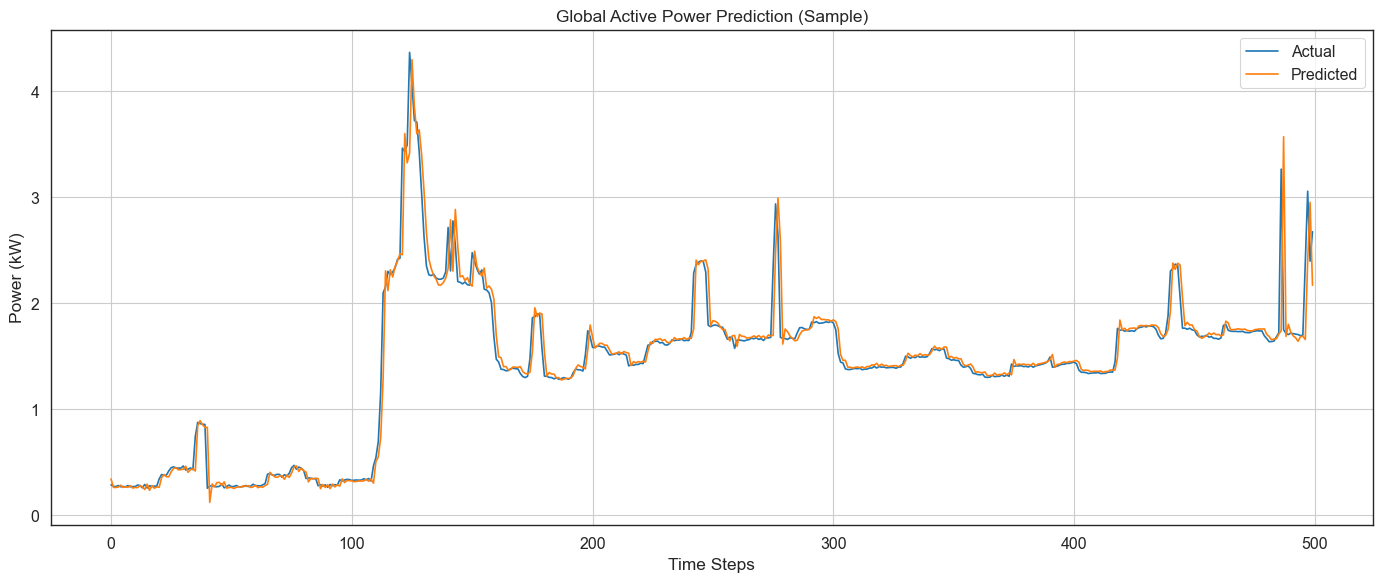

In [48]:
# Predict
predicted = model.predict(X_test_small)
predicted_inv = scaler.inverse_transform(predicted)
actual_inv = scaler.inverse_transform(y_test_small)


plt.figure(figsize=(14, 6))
plt.plot(actual_inv[:500], label='Actual')
plt.plot(predicted_inv[:500], label='Predicted')
plt.title('Global Active Power Prediction (Sample)')
plt.xlabel('Time Steps')
plt.ylabel('Power (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### Step 5: Model Evaluation

##### Step 6: Visualizations